In [2]:
import numpy as np
from ase import Atoms
from gpaw import GPAW, PW, FermiDirac
from gpaw import restart

# Size of the unit cell (Ångstrom)
a = 6.0

# Defining a single H atom at the corner of the cell.
atoms = Atoms('H', positions=[(0, 0, 0)], cell=(a, a, a), pbc=False)

# Defining a GPAW planewave calculator.
calc = GPAW(mode=PW(450),
            xc='PBE',
            txt=None
            )

# Setting the calculator for the atoms and getting the ground-state electron density.
atoms.calc = calc
atoms.get_potential_energy();

In [3]:
from gpaw.utilities.ps2ae import PS2AE
from ase.units import Bohr

# Function for converting the pseudo electron density into the all-electron density on a given fine grid.
h = 0.05
t = PS2AE(calc, grid_spacing=h)

# Smearing width for the nuclear potential.
smear = 0.05 * Bohr

# Function for getting the full electrostatic potential; the sign is flipped and the zero level normalized.
ps2ae = -t.get_electrostatic_potential(rcgauss=smear)
ps2ae -= ps2ae.min()

# Choosing a radial line passing through the nucleus for 1D plotting.
dftpot = ps2ae[0,0]

In [4]:
from abtem.parametrizations import kirkland, load_kirkland_parameters
from abtem.potentials import kappa

# Parameterized potential by Kirkland.
parameters = load_kirkland_parameters()

# Defining a position coordinate and computing the values of the potential (kappa is a conversion factor).
r = np.linspace(0, atoms.cell[0,0], ps2ae.shape[-1])
iampot = kirkland(r[:], parameters[1]) / kappa

In [14]:
from numpy import pi, exp

q = 1.602176*10**-19;
eps0 = 8.854188*10**-12;

# Converting exact solution to Å.
rH = r*10**-10

# Broadens the nuclear part of the potential
width = 1.0280864771910572

# Exact solution of the  electrostatic potential of hydrogen.
#y = q/(4*pi*eps0)*exp(-2*r[1:][:,2]/Bohr)/(rH[1:][:,2]) * (1.0*width + rH[1:][:,2]/Bohr)

y = q / (4 * np.pi * eps0) * (exp(-2 * r / Bohr) / r + exp(-2 * r / Bohr) / Bohr)  * 1e10


/opt/anaconda3/envs/abtem/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in true_divide
  from ipykernel import kernelapp as app


In [8]:
dftpot[1]/y[0]

1.0280864771910572

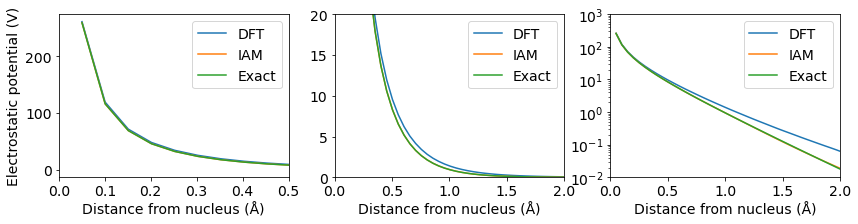

In [15]:
import matplotlib.pyplot as plt

# Plotting the comparison between the three models.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (14,3))

ax1.set_xlim((0.0,0.5));
ax1.plot(r[1:], dftpot[1:], label='DFT')
ax1.plot(r[1:], iampot[1:], label='IAM')
ax1.plot(r[1:], y[1:], label='Exact');
ax1.legend();
ax1.set_xlabel('Distance from nucleus (Å)')
ax1.set_ylabel('Electrostatic potential (V)')

ax2.set_xlim((0.0,2.0));
ax2.set_ylim((0.0,20.0));
ax2.plot(r[1:], dftpot[1:], label='DFT')
ax2.plot(r[1:], iampot[1:], label='IAM')
ax2.plot(r[1:], y[1:], label='Exact');
ax2.legend();
ax2.set_xlabel('Distance from nucleus (Å)')
#ax2.set_ylabel('Electrostatic potential (V)')

ax3.set_xlim((0.0,2.0));
ax3.set_ylim((0.01,1000));
ax3.plot(r[1:], dftpot[1:], label='DFT')
ax3.plot(r[1:], iampot[1:], label='IAM')
ax3.plot(r[1:], y[1:], label='Exact');
ax3.legend();
ax3.set_yscale('log')
ax3.set_xlabel('Distance from nucleus (Å)')
#ax3.set_ylabel('Electrostatic potential (V)')

plt.rcParams['font.size'] = 14